In [1]:
from __future__ import (absolute_import, division,
                        print_function, unicode_literals)
from builtins import *

In [2]:
from io import BytesIO, TextIOWrapper
from zipfile import ZipFile
import csv
from shapely.geometry import Point
import geopandas as gpd
from pyodide.http import pyfetch

response = await pyfetch("https://gaftp.epa.gov/air/emismod/2016/alpha/2016fd/emissions/2016fd_inputs_point.zip")
url = await response.bytes()

VOC, NOx, NH3, SOx, PM2_5 = [], [], [], [], []
height, diam, temp, velocity = [], [], [],  []
coords = []

def add_record(row):
    """ Process one row of the emissions file """
    pol = row[12] # The pollutant is in the 13th column of the CSV file
                  # (In Python, the first column is called column 0.)
    emis = row[13] # We are only extracting annual total emissions here. 
                   # If monthly emissions are reported, we'll miss them.
                   # Emissions are short tons/year.
    if emis == '': return
    if pol in ['VOC', 'VOC_INV', 'XYL', 'TOL', 'TERP', 'PAR', 'OLE', 'NVOL', 'MEOH', 
               'ISOP', 'IOLE', 'FORM', 'ETOH', 'ETHA', 'ETH', 'ALD2', 'ALDX', 'CB05_ALD2', 
               'CB05_ALDX', 'CB05_BENZENE', 'CB05_ETH', 'CB05_ETHA', 'CB05_ETOH', 
               'CB05_FORM', 'CB05_IOLE', 'CB05_ISOP', 'CB05_MEOH', 'CB05_OLE', 'CB05_PAR', 
               'CB05_TERP', 'CB05_TOL', 'CB05_XYL', 'ETHANOL', 'NHTOG', 'NMOG', 'VOC_INV']:
        VOC.append(float(emis))
        NOx.append(0)
        NH3.append(0)
        SOx.append(0)
        PM2_5.append(0)
    elif pol in ['PM25-PRI', 'PM2_5', 'DIESEL-PM25', 'PAL', 'PCA', 'PCL', 'PEC', 'PFE', 'PK', 
                'PMG', 'PMN', 'PMOTHR', 'PNH4', 'PNO3', 'POC', 'PSI', 'PSO4', 'PTI']:
        VOC.append(0)
        NOx.append(0)
        NH3.append(0)
        SOx.append(0)
        PM2_5.append(float(emis))
    elif pol in ['NOX', 'HONO', 'NO', 'NO2']:
        VOC.append(0)
        NOx.append(float(emis))
        NH3.append(0)
        SOx.append(0)
        PM2_5.append(0)
    elif pol == 'NH3':
        VOC.append(0)
        NOx.append(0)
        NH3.append(float(emis))
        SOx.append(0)
        PM2_5.append(0)
    elif pol == 'SO2':
        VOC.append(0)
        NOx.append(0)
        NH3.append(0)
        SOx.append(float(emis))
        PM2_5.append(0)
    else: return
    
    h = row[17]
    height.append(float(h) * 0.3048) if h != '' else height.append(0)
    
    d = row[18]
    diam.append(float(d) * 0.3048) if d != '' else diam.append(0)

    t = row[19]
    temp.append((float(t) - 32) * 5.0/9.0 + 273.15) if t != '' else temp.append(0)
        
    v = row[21]
    velocity.append(float(v) * 0.3048) if v != '' else velocity.append(0)
    
    coords.append(Point(float(row[23]), float(row[24])))

with ZipFile(BytesIO(url)) as zf:
    for contained_file in zf.namelist():
        if "egu" in contained_file: # Only process files with electricity generating unit (EGU) emissions.
            for row in csv.reader(TextIOWrapper(zf.open(contained_file, 'r'), newline='')):
                if (len(row) == 0) or (len(row[0]) == 0) or (row[0][0] == '#'): continue
                add_record(row)

emis = gpd.GeoDataFrame({
    "VOC": VOC, "NOx": NOx, "NH3": NH3, "SOx": SOx, "PM2_5": PM2_5,
    "height": height, "diam": diam, "temp": temp, "velocity": velocity,
}, geometry=coords, crs={'init': 'epsg:4269'})

/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [3]:
# First, we print the first several rows of the dataframe:
emis.head()

,VOC,NOx,NH3,SOx,PM2_5,height,diam,temp,velocity,geometry
0,0.0,0.0,9.0,0.0,0.0,48.768,5.7912,348.15,15.60576,POINT (-86.57383 32.38166)
1,0.0,0.0,8.0,0.0,0.0,48.768,5.7912,348.15,15.60576,POINT (-86.57382 32.38199)
2,0.0,0.0,9.0,0.0,0.0,48.768,5.7912,348.15,15.60576,POINT (-86.57385 32.38032)
3,0.0,0.0,8.0,0.0,0.0,48.768,5.7912,348.15,15.60576,POINT (-86.57384 32.38065)
4,0.0,50.0,0.0,0.0,0.0,48.768,5.7912,348.15,15.60576,POINT (-86.57384 32.38065)


In [4]:
# Now, let's look at the sums of emissions for all power plants (in short tons/year).
emis.sum(axis=0)[["VOC", "NOx", "NH3", "SOx", "PM2_5"]]

<ipython-input-4-fe924cbe62b0>:2: FutureWarning: The default value of numeric_only in GeoDataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  emis.sum(axis=0)[["VOC", "NOx", "NH3", "SOx", "PM2_5"]]


VOC      3.345280e+04
NOx      1.314463e+06
NH3      2.501248e+04
SOx      1.571217e+06
PM2_5    1.408227e+05
dtype: float64

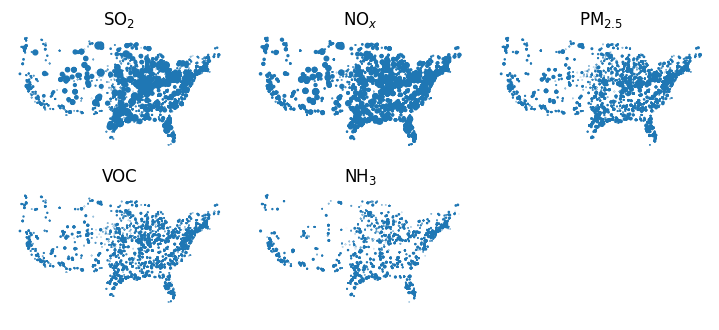

In [5]:
# Finally, lets make some maps of the emissions.

import matplotlib.pyplot as plt
%matplotlib inline

pols = ["SOx", "NOx", "PM2_5", "VOC", "NH3"]
pol_names = ["SO$_2$", "NO$_x$", "PM$_{2.5}$", "VOC", "NH$_3$"]

fig, axes = plt.subplots(figsize=(7, 3), nrows=2, ncols=3, sharex=True, sharey=True)
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.1, hspace=0.1)

i = 0
for x in axes:
    for ax in x:
        if i < len(pols):
            emis.plot(ax=ax, markersize=emis[pols[i]]**0.5 / 5)
            ax.set_title(pol_names[i])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.axis('off')
        i = i+1
plt.show()

In [5]:
# Below are the helper functions for the run_sr function
import time
import numpy as np
import zarr
from shapely.geometry import Polygon, Point
import pandas as pd
import geopandas as gpd
import s3fs

def rect(i, w, s, e, n):
    x = [w[i], e[i], e[i], w[i], w[i]]
    y = [s[i], s[i], n[i], n[i], s[i]]
    return x, y

def poly(sr):
    ret = []
    w = sr["W"][:]
    s = sr["S"][:]
    e = sr["E"][:]
    n = sr["N"][:]
    for i in range(52411):
        x, y = rect(i, w, s, e, n)
        ret.append(Polygon([[x[0],y[0]],[x[1],y[1]],[x[2],y[2]],
                            [x[3],y[3]],[x[4],y[4]]]))
    return ret

<class 'ModuleNotFoundError'>: No module named 's3fs'

In [ ]:
# define the run_sr function
def run_sr(emis, model, emis_units="tons/year"):
    start = time.time()
    url = 's3://inmap-model/isrm_v1.2.1.zarr/'
    fs = s3fs.S3FileSystem(anon=True, client_kwargs=dict(region_name='us-east-2'))
    sr = zarr.open(s3fs.S3Map(url, s3=fs, check=False), mode="r")
#     the following line is used when we access the SR matrix from local files
#     sr = zarr.open("isrm_v1.2.1.zarr", mode="r")

    # build the geometry
    p = poly(sr)
    print("Making polygons as geometry.")

    # took the emis geopandas dataframe
    df = pd.DataFrame({'Location': range(52411)})
    gdf = gpd.GeoDataFrame(df, geometry=p)

    # join the emis dataframe into the grid dataframe
    emis.crs = "+proj=longlat"
    gdf.crs = "+proj=lcc +lat_1=33.000000 +lat_2=45.000000 +lat_0=40.000000 +lon_0=-97.000000 +x_0=0 +y_0=0 +a=6370997.000000 +b=6370997.000000 +to_meter=1"
    emis = emis.to_crs(gdf.crs)
    join_right_df = gdf.sjoin(emis, how="right")
    print("Finished joining the dataframes.")
    
    index = join_right_df.Location.tolist()

    ppl = np.unique(join_right_df.Location.tolist())

    num = range(0,len(ppl))

    dictionary = dict(zip(ppl, num))
        
    SOA = sr['SOA'].get_orthogonal_selection(([0], ppl, slice(None)))
    print("SOA data is allocated.")
    pNO3 = sr['pNO3'].get_orthogonal_selection(([0], ppl, slice(None)))
    print("pNO3 data is allocated.")
    pNH4 = sr['pNH4'].get_orthogonal_selection(([0], ppl, slice(None)))
    print("pNH4 data is allocated.")
    pSO4 = sr['pSO4'].get_orthogonal_selection(([0], ppl, slice(None)))
    print("pSO4 data is allocated.")
    PM25 = sr['PrimaryPM25'].get_orthogonal_selection(([0], ppl, slice(None)))
    print("PrimaryPM25 data is allocated.")
    
    SOA_data, pNO3_data, pNH4_data, pSO4_data, PM25_data = 0.0, 0.0, 0.0, 0.0, 0.0
    for i in range(len(index)):
        SOA_data += SOA[0, dictionary[index[i]], :]*emis.VOC[i]
        pNO3_data += pNO3[0, dictionary[index[i]], :]*emis.NOx[i]
        pNH4_data += pNH4[0, dictionary[index[i]], :]*emis.NH3[i]
        pSO4_data += pSO4[0, dictionary[index[i]], :]*emis.SOx[i]
        PM25_data += PM25[0, dictionary[index[i]], :]*emis.PM2_5[i]
    data = SOA_data + pNO3_data + pNH4_data + pSO4_data + PM25_data

    print("Accessing the data.")
    if emis_units=="tons/year":
        fact = 28766.639

    TotalPM25 = fact * data
    TotalPop = sr['TotalPop'][0:52411]
    MortalityRate = sr['MortalityRate'][0:52411]
    deathsK = (np.exp(np.log(1.06)/10 * TotalPM25) - 1) * TotalPop * 1.0465819687408728 * MortalityRate / 100000 * 1.025229357798165
    deathsL = (np.exp(np.log(1.14)/10 * TotalPM25) - 1) * TotalPop * 1.0465819687408728 * MortalityRate / 100000 * 1.025229357798165
    
    ret = gpd.GeoDataFrame(pd.DataFrame({'SOA': fact * SOA_data,
                                         'pNO3': fact * pNO3_data,
                                         'pNH4': fact * pNH4_data,
                                         'pSO4': fact * pSO4_data,
                                         'PrimaryPM25': fact * PM25_data,
                                         'TotalPM25': TotalPM25,
                                         'deathsK': deathsK,
                                         'deathsL': deathsL}), geometry=p[0:52411])

    print("Finished (%.0f seconds)               "%(time.time()-start))
    return ret